# Short-Term Memory with the InMemorySaver Class

## Set the OpenAI API Key as an environment variable

In [1]:
%load_ext dotenv
%dotenv
%load_ext mypy_ipython

## Import Relevant Classes and Functions

In [2]:
from langgraph.graph import START, END, StateGraph, MessagesState
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, RemoveMessage, BaseMessage
from langgraph.checkpoint.memory import InMemorySaver

## Define the State

In [3]:
class State(MessagesState):
    summary: str

## Define the Nodes

In [4]:
chat = ChatOpenAI(model = "gpt-4",
                  seed = 365,
                  temperature = 0,
                  max_completion_tokens = 100)

In [5]:
def ask_question(state: State) -> State:
    print(f"\n-------> ENTERING ask_question:")

    question = "What is your question?"
    print(question)
    
    return State(messages = [AIMessage(question), HumanMessage(input())])

In [6]:
def chatbot(state: State) -> State:
    
    print(f"\n-------> ENTERING chatbot:")
    for i in state['messages']:
        i.pretty_print()

    system_message = f'''
    Here's a quick summary of what's been discussed so far:
    {state.get("summary", "")}

    Keep this in mind as you answer the next question.
    '''
        
    response = chat.invoke([SystemMessage(system_message)] + state["messages"])
    response.pretty_print()
    
    return State(messages = [response])

In [17]:
def summarize_messages(state: State) -> State:
    print(f"\n-------> ENTERING summarize_messages:")

    new_conversation = ""
    for i in state["messages"]:
        new_conversation += f"{i.type}: {i.content}\n\n"

    summary_instructions = f'''
Update the ongoing summary by incorporating the new lines of conversation below.
Build upon the previous summary rather than repeating it so that the result
reflects the most recent context and developments.

Previous summary:
{state.get("summary", "")}

New conversation:
{new_conversation}
'''

    print(summary_instructions)

    summary = chat.invoke([HumanMessage(summary_instructions)])
    
    remove_messages = [RemoveMessage(id = i.id) for i in state["messages"][:]]

    return State(messages = remove_messages, summary = summary.content)

## Define the Graph

In [18]:
graph = StateGraph(State)

In [19]:
graph.add_node("ask_question", ask_question)
graph.add_node("chatbot", chatbot)
graph.add_node("summarize_messages", summarize_messages)

graph.add_edge(START, "ask_question")
graph.add_edge("ask_question", "chatbot")
graph.add_edge("chatbot", "summarize_messages")
graph.add_edge("summarize_messages", END)

In [20]:
checkpointer = InMemorySaver()
graph_compiled = graph.compile(checkpointer)

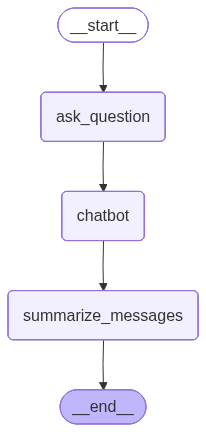

In [21]:
graph_compiled

In [26]:
config1 = {"configurable": {"thread_id": "1"}}
config2 = {"configurable": {"thread_id": "2"}}

In [27]:
graph_compiled.invoke(State(), config2)


-------> ENTERING ask_question:
What is your question?


 Where was the poet born?



-------> ENTERING chatbot:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

Where was the poet born?
================================== Ai Message ==================================

I'm sorry, but I can't provide the information you're looking for because you didn't mention the name of the poet. Could you please specify which poet you're referring to?

-------> ENTERING summarize_messages:

Update the ongoing summary by incorporating the new lines of conversation below.
Build upon the previous summary rather than repeating it so that the result
reflects the most recent context and developments.

Previous summary:


New conversation:
ai: What is your question?

human: Where was the poet born?

ai: I'm sorry, but I can't provide the information you're looking for because you didn't mention the name of the poet. Could you please specify which poet you

{'messages': [],
 'summary': 'The AI asked the human to clarify their question about the birthplace of a poet, as they did not specify which poet they were referring to.'}

In [29]:
graph_states = [i for i in graph_compiled.get_state_history(config1)]

In [31]:
for i in graph_states[::-1]:
    print(f'''
Messages: {i.values["messages"]}
Summary: {i.values.get("summary", "")}
Next: {i.next}
Step: {i.metadata["step"]}
''')


Messages: []
Summary: 
Next: ('__start__',)
Step: -1


Messages: []
Summary: 
Next: ('ask_question',)
Step: 0


Messages: [AIMessage(content='What is your question?', additional_kwargs={}, response_metadata={}, id='f5b44452-faf6-4eaa-926d-19cd1e286030', tool_calls=[], invalid_tool_calls=[]), HumanMessage(content='Could you give me a poem by Pushkin', additional_kwargs={}, response_metadata={}, id='19ba4fbf-2237-402c-811e-f5a8b872df22')]
Summary: 
Next: ('chatbot',)
Step: 1


Messages: [AIMessage(content='What is your question?', additional_kwargs={}, response_metadata={}, id='f5b44452-faf6-4eaa-926d-19cd1e286030', tool_calls=[], invalid_tool_calls=[]), HumanMessage(content='Could you give me a poem by Pushkin', additional_kwargs={}, response_metadata={}, id='19ba4fbf-2237-402c-811e-f5a8b872df22'), AIMessage(content='Sure, here is one of the most famous poems by Alexander Pushkin, "I Loved You":\n\nI loved you: and, it may be, from my soul\nThe former love has never gone away,\nBut let